# Исследование влияния наличия нескольких экспоненциальных составляющих в спектре на коэффициент нелинейности-неэкспоненциальности

## 1. Импорт необходимых библиотек и модулей

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
from joblib import Parallel, delayed

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline

from fsmodels import SklSingleExpFrequencyScan

from fsplots import plot_model
from fsplots import plot_loss_path
from fsplots import plot_experimental_points

## 2. Модель частотного скана с для сигнала релаксации с одной экспоненциальной составляющей и коэффициентом нелинейности-неэкспоненциальности

### 2.1.  Описание модели в формулах
Выходной сигнал коррелятора спектрометра DLS-82E определяется выражением:
\begin{equation}
    \label{eq:eq1}
    S\left(\tau,C_A,F_0, t_1\right) = C_A K_{BS} K_{LS} \phi\left(\tau,F_0,t_1\right),
\end{equation}
где  
$C_A$ - амплитуда емкостного релаксационного сигнала,  
$K_{BS}$ - масштабный коэффициент, зависящий от чувствительности емкостного моста,  
$K_{LS}$ - масштабный коэффициент селектора,  
$\tau$ - постоянная времени релаксации гулбокого уровня,  
$F_0$ - частота сканирования импульсов заполнения,  
$t_1$ - длительность импульса заполнения,  
$\phi\left(\tau,F_0,t_1\right)$ - функция определяемая выражением:  
\begin{equation}
    \label{eq:eq2}
    \phi\left(\tau,F_0,t_1\right) = 
    M \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right),
\end{equation}
где $M$ - масштабный множитель.

$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

### 2.2. Кодирование модели
$$ \tau = 10^{time\_constant\_power} $$

$$ F_0 = 10^{frequency\_power}$$

$$ a = \tau F_0 $$

$$ b = t_1 F_0 $$

$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$

$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$

$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$

$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$

$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

$$  M = \frac{1}{\max{\left[
    a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right)
    \right]}}
$$

$$ S\left(\tau, A, F_0, t_1, p\right) = A\left[\phi\left(\tau,F_0,t_1\right)\right]^p $$

```Python
from fsmodels import SklSingleExpFrequencyScan
```

## 3. Проверка модели. Пример 1.
- Постоянная времени: $\tau=0.005$ с.
- Амплитуда: $A=3.0$ .
- Длительность импульса заполнения: $t_1=20\cdot10^{-6}$ с.
- Коэффициент нелинейности-неэкспоненциальности: $p=1.0$

### 3.1. Чтение данных

In [3]:
data = pd.read_csv('test.csv', header = 0)
data['temperature_k'] = 298.0
data = data[['f_pulse', 'temperature_k', 'frequency_hz', 'dlts_pf']]

f_pulse = data.loc[0,'f_pulse']

data.head()

,f_pulse,temperature_k,frequency_hz,dlts_pf
0,0.00002,298.0,1.000000,0.024528
1,0.00002,298.0,1.007863,-0.200976
2,0.00002,298.0,1.015787,0.004056
3,0.00002,298.0,1.023774,0.252659
4,0.00002,298.0,1.031823,0.307020


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   f_pulse        1000 non-null   float64
 1   temperature_k  1000 non-null   float64
 2   frequency_hz   1000 non-null   float64
 3   dlts_pf        1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


### 3.2 График данных до масштабирования

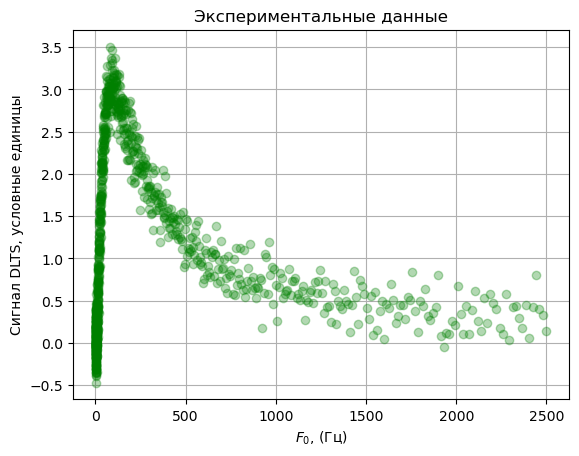

In [5]:
plot_experimental_points(X = data.frequency_hz, y = data.dlts_pf)
plt.xlabel('$F_0$, (Гц)')
plt.show()

### 3.3. Нормализация (масштабирование) данных
Переход к десятичному логарифму частоты

In [6]:
data.frequency_hz = np.log10(data.frequency_hz)
data.head()

,f_pulse,temperature_k,frequency_hz,dlts_pf
0,0.00002,298.0,0.000000,0.024528
1,0.00002,298.0,0.003401,-0.200976
2,0.00002,298.0,0.006803,0.004056
3,0.00002,298.0,0.010204,0.252659
4,0.00002,298.0,0.013605,0.307020


### 3.4. График данных после нормализации 

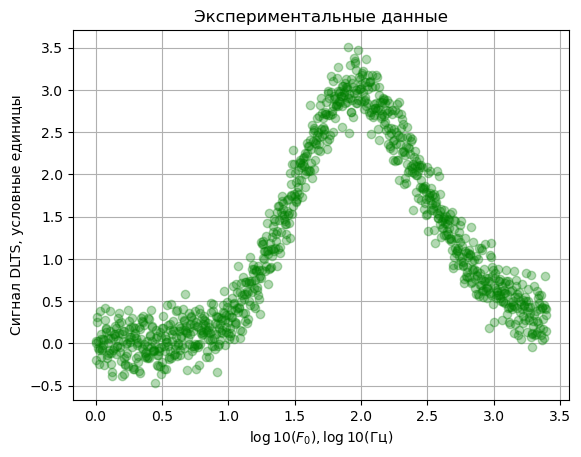

In [7]:
plot_experimental_points(X = data.frequency_hz, y = data.dlts_pf)
plt.show()

### 3.5. Идентификация параметров модели без изменения $p$

In [9]:
fs = SklSingleExpFrequencyScan(filling_pulse = f_pulse, 
                               fit_p_coef = False,
                               learning_rate = 0.2,
                               n_iters = 1000,
                               stop_val = 10**-10,
                               verbose = True)

fs.fit(X=data.frequency_hz, y = data.dlts_pf)

fit_results = fs.fit_results_

2022-09-19 08:01:40.399662: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-19 08:01:40.399683: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-19 08:01:40.399687: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-19 08:01:40.399764: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-19 08:01:40.399776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-19 08:01:40.399779: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-19 08:01:40.399951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

iteration # 0
loss: 1.919611024782664
exps_params:
[[-2.54795056  0.33768426]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 1
loss: 1.5796543691884135
exps_params:
[[-2.49961846  0.59809093]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 2
loss: 1.279346405697907
exps_params:
[[-2.42909002  0.83754693]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 3
loss: 1.0271070848743145
exps_params:
[[-2.3629784   1.05874722]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 4
loss: 0.8270147640423998
exps_params:
[[-2.32023197  1.26056577]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 5
loss: 0.

iteration # 42
loss: 0.03787098100563868
exps_params:
[[-2.30043212  2.96872739]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 43
loss: 0.03783645117293979
exps_params:
[[-2.30044098  2.97142696]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 44
loss: 0.037808784089129986
exps_params:
[[-2.3004489   2.97384342]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 45
loss: 0.03778661579273134
exps_params:
[[-2.300456    2.97600645]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 46
loss: 0.037768853407971065
exps_params:
[[-2.30046235  2.97794264]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteratio

iteration # 84
loss: 0.03769726027800557
exps_params:
[[-2.30051574  2.9942233 ]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 85
loss: 0.03769725714114159
exps_params:
[[-2.30051582  2.99424903]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 86
loss: 0.037697254627723054
exps_params:
[[-2.3005159   2.99427206]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 87
loss: 0.03769725261384154
exps_params:
[[-2.30051597  2.99429268]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteration # 88
loss: 0.037697251000214926
exps_params:
[[-2.30051603  2.99431113]]
p_coef: 1.0
filling_pulse: 2e-05
fit_p_coef: False
learning_rate: 0.2
n_iters: 1000
stop_val: 1e-10
verbose: True


iteratio

In [10]:
fit_results.to_csv('../models/identification_test.csv', index=False)
fit_results

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
0,0.337684,0.00002,False,0.2,1.919611,1,1000,1.0,1.000000e-10,-2.547951,True
1,0.598091,0.00002,False,0.2,1.579654,1,1000,1.0,1.000000e-10,-2.499618,True
2,0.837547,0.00002,False,0.2,1.279346,1,1000,1.0,1.000000e-10,-2.429090,True
3,1.058747,0.00002,False,0.2,1.027107,1,1000,1.0,1.000000e-10,-2.362978,True
4,1.260566,0.00002,False,0.2,0.827015,1,1000,1.0,1.000000e-10,-2.320232,True
...,...,...,...,...,...,...,...,...,...,...,...
97,2.994411,0.00002,False,0.2,0.037697,1,1000,1.0,1.000000e-10,-2.300516,True
98,2.994417,0.00002,False,0.2,0.037697,1,1000,1.0,1.000000e-10,-2.300516,True
99,2.994422,0.00002,False,0.2,0.037697,1,1000,1.0,1.000000e-10,-2.300516,True
100,2.994427,0.00002,False,0.2,0.037697,1,1000,1.0,1.000000e-10,-2.300516,True


### 3.6. График с результатами идентификации модели

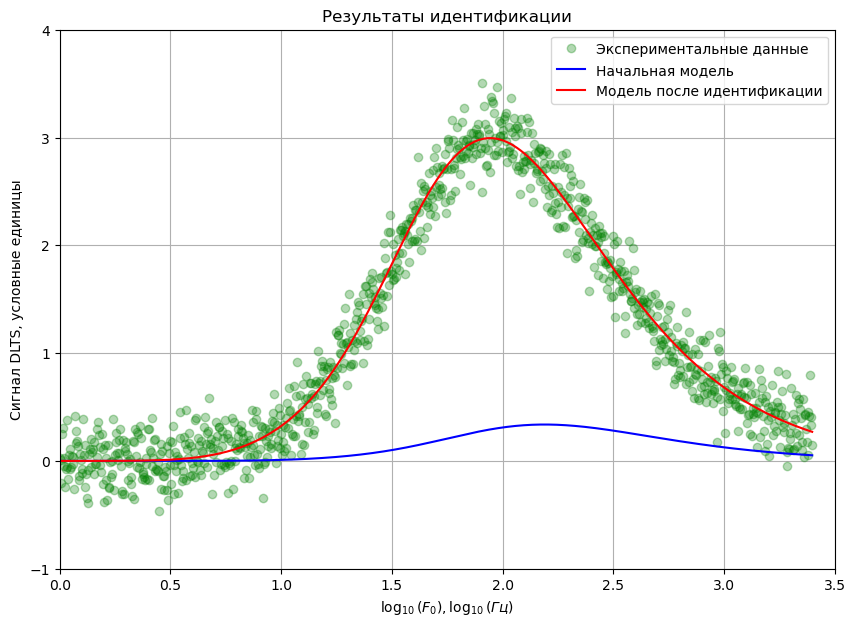

In [14]:
fig, ax = plot_model(X=data.frequency_hz, 
                     y=data.dlts_pf, 
                     model_class=SklSingleExpFrequencyScan,
                     fit_results_=fit_results,
                     plot_exps=False
                    )

plt.savefig('../plots/identification_test.pdf', bbox_inches='tight')
plt.savefig('../plots/identification_test.jpg', bbox_inches='tight')

plt.show()

### 3.8. График изменения параметров во время оптимизации

In [15]:
def get_mse(x, y, model_class, freq, dlts):
    
    model.time_constant_power = tf.Variable(y, dtype='float64')
    model.amplitude = tf.Variable(x, dtype='float64')
    
    
    mse = tf.reduce_mean(tf.square(dlts - model(freq))).numpy()

    return mse

def get_mse_grid(time_constant_powers, 
                 amplitudes, 
                 model_class, 
                 actual_freq, 
                 actual_dlts, 
                 n_jobs=1):
    
    X, Y = np.meshgrid(amplitudes, time_constant_powers)
    
    x = X.flatten()
    y = Y.flatten()
    
    Z = Parallel(n_jobs=n_jobs)(delayed(get_mse)(a, b, fs, data[:,2], data[:,3]) for a, b in zip(x, y))
    Z = np.reshape(np.c_[Z], X.shape)
    
    return X, Y, Z

def plot_path(X, Y, Z, 
              x_path, 
              y_path, 
              x_label='amplitude',
              y_label='time constant power'
             ):
    
    fig, ax = plt.subplots(figsize=(14,10))
    CS = ax.contour(X, Y, Z, 
                    levels=[0, 0.05, 0.1, 0.25, 0.5, 1, 2.0, 3.0, 4.0, 5.0], 
                    colors='k')
    ax.clabel(CS, 
              inline=True, 
              fontsize=12)

    IM = ax.imshow(Z, 
                   interpolation='bilinear', 
                   origin='lower',
                   cmap=cm.PuBuGn, 
                   extent=(np.min(X), np.max(X), np.min(Y), np.max(Y)), 
                   vmin=0, 
                   vmax=np.round(Z.max()))

    ax.plot(x_path, y_path, 'o-r')
    
    cbar = fig.colorbar(IM, shrink=1)
    cbar.ax.set_ylabel('Среднеквадратическая ошибка')

    ax.set_title('Значения параметров модели в процессе идентификации')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.grid()
    
    return fig, ax

In [16]:
amplitudes = np.linspace(2, 4, 40)
time_constant_powers = np.linspace(-3, -1, 40)

X, Y, Z = get_mse_grid(time_constant_powers = time_constant_powers, 
                       amplitudes = amplitudes,
                       model = fs,
                       actual_freq = data[:, 2],
                       actual_dlts = data[:, 3],
                       n_jobs=-1
                      )

fig, ax = plot_path(X, Y, Z, 
                    x_path=fit_results.amplitude_0.to_numpy(),
                    y_path=fit_results.time_constant_power_0.to_numpy(), 
                    x_label='Амплитуда, yсловные единицы',
                    y_label='log10(Постоянная времени), log10(с)')

plt.savefig('../plots/path.pdf', bbox_inches='tight')
plt.savefig('../plots/path.jpg', bbox_inches='tight')
                    
plt.show()

InvalidIndexError: (slice(None, None, None), 2)